# No comments / code are final

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# This is for the plots not being cut off
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Data Cleaning

### What are the stats?

1. Sleep
    * Time in bed(hr)
    * The sleep data was collected on my iphone and it tracked everytime after 10pm that I stopped using my phone for more than 15 minutes
    * Something to keep in mind is that the sleep time is reset whenever I picked up my phone
1. Audio
    * Headphone sound levels(dBASPL)
    * The audio data was collected on my iphone at random intervals and it would keep track of the current decibal levels (db)
1. Movement
    * Distance walking / running(mi)
        * The amount of miles I traversed in a specific day
    * Flights climbed(count)
        * The amount of flights of stairs I climbed
    * Step count(count)
        * The amount of steps I took in a given day

### My proccess of Data Cleaning

* Import the values into either series or dataframes
* Convert the values to the right datatype
    * The movement data will not be altered
    * Any sleep data that is less than half an hour is considered a nap and will not included
    *  For audio i will take the average for each day since the data was collected at random intervals

## Questions
1. Why it the domain important to you and why you are researching in this domain
    * I am curious about the difference between in school and out of school for my movement, and since I have the option to do sleep and headphone volume I thought it would be interesting to explore them.
1. What is the dataset format (e.g. CSV files, JSON files, a mix of the two, etc.)
    * all three datasets are in .csv files
1. What tables are included in the dataset and how is the data in each table collected
    * All data is collected from my iPhone (see `What are the stats?` for each of the attributes)
1. Include a brief description of the attributes
    * See `What are the stats?`
1. What are you trying to classify in the dataset
    * I want to clearly show the difference in physical activity during the summer. Adding onto that I want to see if there is a differnce between my physical activity/headphone usage/sleep schedule during the weekdays versus the weekend.
1. What are potential impacts of the results
    * Headphone saftey:
        * If I notice that I listen to louder music during a specific time of the year, I can look out for that and notice and turn down the volume
    * Sleep schedule:
        * If I notice that I get way less sleep on the weekdays, it can allow for me to plan my week better and allow for me to get a consistent amount of sleep on both the weekend and weekdays
    * Physical activity:
        * The main reason for this project would be for me to visually see just how much less activities I did over the summer since my job was a delivery driver
1. Who are stakeholders interested in your results
    * Me
    * Maybe my doctors who would want to monitor my sleep schedule or physical activities

## Movement

In [2]:
movement_data = pd.Series(dtype=float)
movement_data = pd.read_csv("original_data/puryear_movement.csv", index_col=0)
movement_data.to_csv("data/cleaned_puryear_movement.csv")

print(movement_data)

            Distance walking / running(mi)  Flights climbed(count)  \
Date                                                                 
2020-11-21                           1.023                     5.0   
2020-11-22                           1.202                     2.0   
2020-11-23                           2.455                     8.0   
2020-11-24                           1.165                     4.0   
2020-11-25                           2.444                     3.0   
...                                    ...                     ...   
2021-11-17                           2.624                     7.0   
2021-11-18                           4.532                     7.0   
2021-11-19                           3.492                    10.0   
2021-11-20                           0.507                     4.0   
2021-11-21                           0.004                     0.0   

            Step count(count)  
Date                           
2020-11-21           2471

## Audio

format = `%YYYY-%MM-%DD %HH:%MM:%%SS - %YYYY-%MM-%DD %HH:%MM:%%SS,%DB_Val`

In [3]:
audio_data = pd.DataFrame(dtype=float)
audio_data = pd.read_csv("original_data/puryear_audio.csv")

# idea for repeating values, find the daily average

audio_data_cleaned = pd.Series(dtype=float)

for i in range(len(audio_data)):
    audio_data_date_string = audio_data.iloc[i]["Date"]
    cropped_audio_date_string = audio_data_date_string[0:19]
    audio_data_cleaned[cropped_audio_date_string] =  audio_data.iloc[i]["Headphone sound levels(dBASPL)"]

In [4]:
audio_data_cleaned = audio_data_cleaned.reset_index()
audio_data_cleaned.columns=["Unnamed: 0","0"]

## Combining the dates of the audio

In [5]:
audio_data_cleaned_again = pd.Series(dtype=float)

# finding the average of the daily values
sum = 1
amount = audio_data_cleaned.iloc[0][1]
audio_data_cleaned_prev_date = audio_data_cleaned.iloc[0][0][0:10]

# yes this works!
for i in range(1,len(audio_data_cleaned)):
    audio_data_cleaned_date = audio_data_cleaned.iloc[i][0][0:10]
    if audio_data_cleaned_date == audio_data_cleaned_prev_date: # if this date is the same as the day before do this
        sum = sum + 1
        amount = amount + audio_data_cleaned.iloc[i][1]
    else: # otherwise reset all the values and continue
        sum = 1
        amount = audio_data_cleaned.iloc[i][1]
        audio_data_cleaned_prev_date = audio_data_cleaned.iloc[i][0][0:10]
        audio_data_cleaned_again[audio_data_cleaned_date] = (amount / sum)

In [6]:
audio_data_cleaned = pd.DataFrame(audio_data_cleaned_again)
audio_data_cleaned.columns = ["Headphone sound levels(dBASPL)"]
audio_data_cleaned.rename_axis("Date",inplace=True)
audio_data_cleaned.to_csv("data/cleaned_puryear_audio.csv")

print(audio_data_cleaned)

            Headphone sound levels(dBASPL)
Date                                      
2020-11-22                          66.064
2020-11-23                          61.650
2020-11-24                          54.927
2020-11-25                          57.506
2020-11-26                          39.405
...                                    ...
2021-11-17                          65.809
2021-11-18                          62.816
2021-11-19                          57.094
2021-11-20                          59.618
2021-11-21                          60.938

[363 rows x 1 columns]


### Function that combines the days

In [7]:
def combine_days_in_ser(original_series):
    # finding the average of the daily values
    sum = 1
    amount = original_series.iloc[0][1]
    prev_date = original_series.iloc[0][0][0:10]

    cleaned_series = pd.Series(dtype=float)

    # print(len(original_series))
    # yes this works!
    for i in range(1,len(original_series)):
        original_series_date = original_series.iloc[i][0][0:10]
        if original_series_date == prev_date: # if this date is the same as the day before do this
            sum = sum + 1
            amount = amount + original_series.iloc[i][1]
        else: # otherwise reset all the values and continue
            sum = 1
            amount = original_series.iloc[i][1]
            prev_date = original_series.iloc[i][0][0:10]
            cleaned_series[original_series_date] = amount

    return cleaned_series

## Sleep

Format = `%YYYY-%MM-%DD %HH:%MM:%%SS - %YYYY-%MM-%DD %HH:%MM:%%SS,%DB_Val`

In [8]:
sleep_data = pd.Series(dtype=float)

sleep_data = pd.read_csv("original_data/puryear_sleep.csv")

# i notice how whenever there is a super small one, its always after a longer one.
# my theory is that that is when i actually pick up my phone first, but then i put it down.
# maybe i hit snooze

# first thing i am going to do is see if i can get the first value before the -, i feel like the stuff after the dash is not needed since we will have the value

sleep_data_cleaned = pd.Series(dtype=float)

for i in range(len(sleep_data)):
    current_date_string = sleep_data.iloc[i]["Date"]
    cropped_date_string = current_date_string[0:19]
    sleep_data_cleaned[cropped_date_string] =  sleep_data.iloc[i]["Time in bed(hr)"]


In [9]:
# #sleep_data_cleaned = pd.read_csv("data/temporary_sleep.csv")
# sleep_data_cleaned = pd.DataFrame(combine_days_in_ser(sleep_data_cleaned.reset_index()))
sleep_data_cleaned = sleep_data_cleaned.reset_index()
sleep_data_cleaned.columns=["Unnamed: 0","0"]
sleep_data_cleaned = combine_days_in_ser(sleep_data_cleaned)
print(sleep_data_cleaned)

2020-11-22    0.001
2020-11-23    6.531
2020-11-24    4.332
2020-11-25    6.544
2020-11-26    8.158
              ...  
2021-11-17    7.020
2021-11-18    4.149
2021-11-19    7.006
2021-11-20    4.853
2021-11-21    6.994
Length: 340, dtype: float64


In [10]:
sleep_data_cleaned = pd.DataFrame(sleep_data_cleaned)
sleep_data_cleaned.columns =["Time in bed(hr)"]
sleep_data_cleaned.rename_axis("Date",inplace=True)

sleep_data_cleaned.to_csv("data/cleaned_puryear_sleep.csv")

print(sleep_data_cleaned)

            Time in bed(hr)
Date                       
2020-11-22            0.001
2020-11-23            6.531
2020-11-24            4.332
2020-11-25            6.544
2020-11-26            8.158
...                     ...
2021-11-17            7.020
2021-11-18            4.149
2021-11-19            7.006
2021-11-20            4.853
2021-11-21            6.994

[340 rows x 1 columns]


# EDA

## Questions
1. What cleaning of the dataset did you need to perform(e.g.. are there missing values and how did you handle the missing values)
    * The main thing that I am doing is finding a good way to combine the multiple sleep data points.  
        * I could wake up and use my phone from 1 to even 4 times in a single night, be it not being able to sleep or checking the time
1. How are you merging the tables
    * I am merging the tables based off of their date, and later the day of the week
1. What are challenges with data preparation
    * The main challange was with combining multiple sleep data points, since there could be multiple logs for the same "sleep session", but those logs could be from different days:
        * e.g. sunday at 11:32pm i slept for 33 minutes and the next dataset is monday at 12:05am
        * Even though these data points are from different days, they are still back to back and part of the same "nights sleep"
1. What data aggregation techniques are you applying
    * Making sure everything is labeled 
    * Adding day of the week
    * Cleaning up invalid sleep data points (less than half an hour)
1. What visualizations informatively present the attributes and relationships
    * A line graph is perfect for visualizing the graphs, especially since it is based off of the date
1. What statistical hypothesis tests are you computing
    * My hypothesis is that there is no difference between the weekend and weekdays for the amount of sleep i get / audio levels / and movement
        * This might sound weird but I like to think I keep a consistent sleep schedule

## Graphs

### Combine all 3 dataframes 

In [11]:
movement_data = pd.DataFrame(dtype=float)
movement_data = pd.read_csv("data/cleaned_puryear_movement.csv",index_col=0)

audio_data = pd.DataFrame(dtype=float)
audio_data = pd.read_csv("data/cleaned_puryear_audio.csv",index_col=0)
# audio_data.columns = ["Date","Headphone sound levels(dBASPL)"]

sleep_data = pd.DataFrame(dtype=float)
sleep_data = pd.read_csv("data/cleaned_puryear_sleep.csv",index_col=0)
# sleep_data.columns = ["Date","Time in bed(hr)"]

In [12]:
sleep_and_audio_data = pd.merge(sleep_data,audio_data,on="Date")
all_data = pd.merge(sleep_and_audio_data,movement_data, on="Date")

### Movement

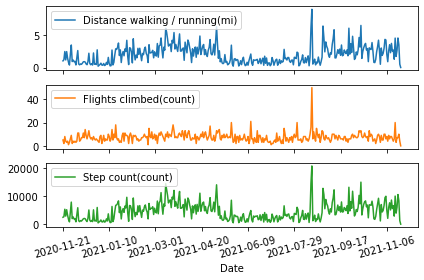

In [13]:
ax = movement_data.plot(subplots=True,rot=15)
fig = ax[0].get_figure()
fig.savefig("figures/movement_graph.jpg",dpi=500)

### Audio

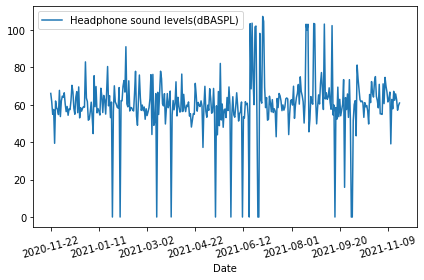

In [14]:
ax = audio_data.plot(subplots=True,rot=15)
fig = ax[0].get_figure()
fig.savefig("figures/audio_graph.jpg",dpi=500)

### Sleep

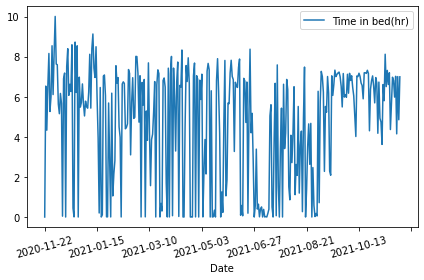

In [15]:
ax = sleep_data.plot(subplots=True,rot=15)
fig = ax[0].get_figure()
fig.savefig("figures/sleep_graph.jpg",dpi=500)

### All Data

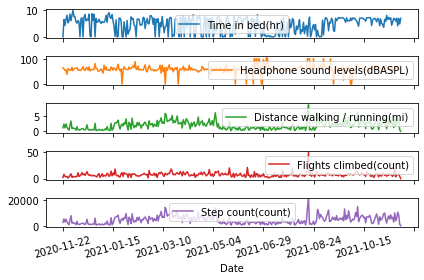

In [16]:
ax = all_data.plot(subplots=True,rot=15)
fig = ax[0].get_figure()
fig.savefig("figures/combined_graph.jpg",dpi=500)

### Combined Graph
<img src="https://raw.githubusercontent.com/Ben10164/CPSC222_Project/master/figures/combined_graph.jpg" width="600"/>

## Interpolate data for VISUAL analysis

In [17]:
# making new dataframes
movement_data = pd.DataFrame(dtype=float)
movement_data = pd.read_csv("data/cleaned_puryear_movement.csv")

audio_data = pd.DataFrame(dtype=float)
audio_data = pd.read_csv("data/cleaned_puryear_audio.csv")
audio_data.columns = ["Date","Headphone sound levels(dBASPL)"]

sleep_data = pd.DataFrame(dtype=float)
sleep_data = pd.read_csv("data/cleaned_puryear_sleep.csv")
sleep_data.columns = ["Date","Time in bed(hr)"]

### Audio

In [18]:
# interpolate audio data
audio_data.mask((audio_data["Headphone sound levels(dBASPL)"] <= 30) & (audio_data["Headphone sound levels(dBASPL)"] <= 100),inplace=True) # filtering out the outliers
audio_data.interpolate(method="cubic",inplace=True)
audio_data.fillna(method="bfill",inplace=True)

In [19]:
audio_data_combined = audio_data.merge(audio_data["Headphone sound levels(dBASPL)"].ewm(alpha=0.1).mean(),left_index=True,right_index=True)
audio_data_combined.columns=["Date","Headphone sound levels(dBASPL)","Headphone sound levels(dBASPL) MOVING AVERAGE"]

audio_data_combined.set_index("Date",inplace=True)

audio_data_combined.to_csv("data/cleaned_puryear_audio_ewm.csv")

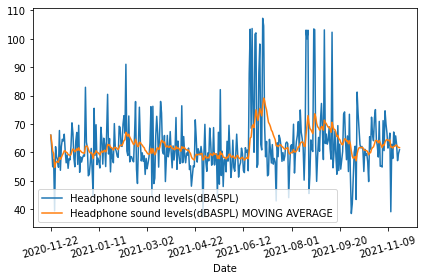

In [20]:
ax = audio_data_combined.plot(rot=15)
fig = ax.get_figure()
fig.savefig("figures/moving_avg_audio_graph.jpg",dpi=500)

<img src="https://raw.githubusercontent.com/Ben10164/CPSC222_Project/master/figures/moving_avg_audio_graph.jpg" width="600"/>

### Sleep

In [21]:
# interpolate sleep data
sleep_data.interpolate(method="cubic",inplace=True)
sleep_data.fillna(method="bfill",inplace=True)

In [22]:
sleep_data_combined = sleep_data.merge(sleep_data["Time in bed(hr)"].ewm(alpha=0.1).mean(),left_index=True,right_index=True)
sleep_data_combined.columns=["Date","Time in bed(hr)","Time in bed(hr) MOVING AVERAGE"]

sleep_data_combined.set_index("Date",inplace=True)

sleep_data_combined.to_csv("data/cleaned_puryear_sleep_ewm.csv")

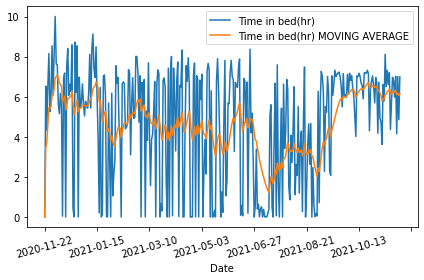

In [23]:
ax = sleep_data_combined.plot(rot=15)
fig = ax.get_figure()
fig.savefig("figures/moving_avg_sleep_graph.jpg",dpi=500)

<img src="https://raw.githubusercontent.com/Ben10164/CPSC222_Project/master/figures/moving_avg_sleep_graph.jpg" width="600"/>

### Movement

In [24]:
# interpolate movement data
movement_data.interpolate(method="cubic",inplace=True)
movement_data.fillna(method="bfill",inplace=True)

movement_data_distance = pd.DataFrame(movement_data["Distance walking / running(mi)"])
movement_data_flights = pd.DataFrame(movement_data["Flights climbed(count)"])
movement_data_step = pd.DataFrame(movement_data["Step count(count)"])

In [25]:
# reset indexes
movement_data_distance.set_index(movement_data["Date"],inplace=True)
movement_data_flights.set_index(movement_data["Date"],inplace=True)
movement_data_step.set_index(movement_data["Date"],inplace=True)

# create the combined datasets
movement_data_distance_combined = movement_data_distance.merge(movement_data_distance["Distance walking / running(mi)"].ewm(alpha=0.1).mean(),left_index=True,right_index=True)
movement_data_flights_combined = movement_data_flights.merge(movement_data_flights["Flights climbed(count)"].ewm(alpha=0.1).mean(),left_index=True,right_index=True)
movement_data_step_combined = movement_data_step.merge(movement_data_step["Step count(count)"].ewm(alpha=0.1).mean(),left_index=True,right_index=True)


In [26]:
# rename the columns
movement_data_distance_combined.columns=["Distance walking / running(mi)","Distance walking / running(mi) MOVING AVERAGE"]
movement_data_flights_combined.columns=["Flights climbed(count)","Flights climbed(count) MOVING AVERAGE"]
movement_data_step_combined.columns=["Step count(count)","Step count(count) MOVING AVERAGE"]

In [27]:
# output to csv
movement_data_distance_combined.to_csv("data/clean_puryear_movement_distance_ewm.csv")
movement_data_flights_combined.to_csv("data/clean_puryear_movement_flights_ewm.csv")
movement_data_step_combined.to_csv("data/clean_puryear_movement_step_ewm.csv")

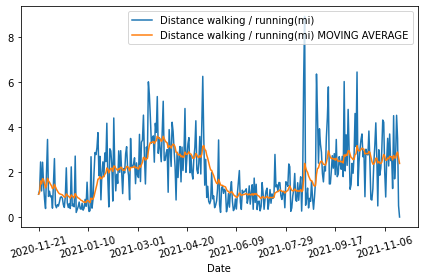

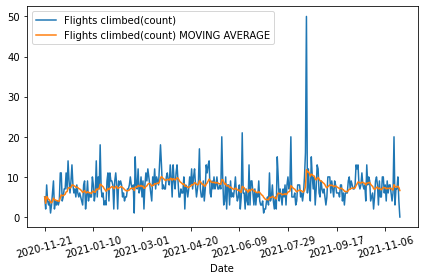

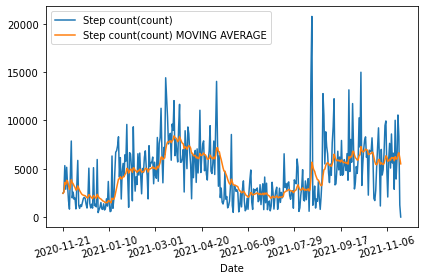

In [28]:
# create and output plots
ax = movement_data_distance_combined.plot(rot=15)
fig = ax.get_figure()
fig.savefig("figures/moving_avg_movement_distance_graph.jpg",dpi=500)

ax = movement_data_flights_combined.plot(rot=15)
fig = ax.get_figure()
fig.savefig("figures/moving_avg_movement_flights_graph.jpg",dpi=500)

ax = movement_data_step_combined.plot(rot=15)
fig = ax.get_figure()
fig.savefig("figures/moving_avg_movement_steps_graph.jpg",dpi=500)

## Observations

* The first thing that sticks out is how obvious it is when I am at school vs home.
    * The step count decreases alot during the summer
    * The distance walking / running decreases during the summer
* On the 17th of August there is a large spike for flights climbed
    * This was when a friend was visiting and we went hiking
* There is a very clear dip in my sleep during late July and early August
* Early June there is an extremly large spike in db for the headphone sound levels
    * This is most likely because it was around that time that I started my job as a delivery driver
* There is a clear difference between the first half of Spring 2020 and the second half for distance walking / running
    * This is most likely because early March I started dating someone who lived across the campus



# Hypothesis / Testing

## T-test

##### The subject has exported his iPhones movement data, as well as his sleep and headphone volume data. Using a level of significance of 0.1, is there any major difference between the data for the weekdays vs the weekends?
* Null Hypothesis:
    * There is no significant difference: $\alpha \le 0.1$
* Alternate Hypothesis:
    * There is a significant difference: $\alpha \gt 0.1$

In [29]:
# return the date of the week of a given date in the format of 'YYYY-MM-DD'
def get_weekday(date):
    return pd.to_datetime(date).strftime('%A')

audio_df = pd.read_csv("data/cleaned_puryear_audio.csv",index_col=0)
movement_df = pd.read_csv("data/cleaned_puryear_movement.csv",index_col=0)
sleep_df = pd.read_csv("data/cleaned_puryear_sleep.csv",index_col=0)

In [30]:
def return_dataframe_of_weekend(df):
    df = df.reset_index()
    weekday_df = pd.DataFrame()
    weekday_df['Weekday'] = df['Date'].apply(get_weekday)
    df = df.join(weekday_df)
    sunday_and_saturday_df = df[df['Weekday'] == 'Sunday'].append(df[df['Weekday'] == 'Saturday']) # append the dataframe of all weekends
    sunday_and_saturday_df['Date'] = pd.to_datetime(sunday_and_saturday_df['Date']) # convert to datetime
    sunday_and_saturday_df['Date'] = sunday_and_saturday_df['Date'].dt.strftime('%Y-%m-%d') # set the format of the date to 'YYYY-MM-DD'
    sunday_and_saturday_df = sunday_and_saturday_df.sort_values(by=['Date']) # sort by date
    sunday_and_saturday_df.set_index("Date",inplace=True)
    return sunday_and_saturday_df

weekend_audio_df = return_dataframe_of_weekend(audio_df)
weekend_movement_df = return_dataframe_of_weekend(movement_df)
weekend_sleep_df = return_dataframe_of_weekend(sleep_df)

In [31]:
def return_dataframe_of_weekday(df):
    df = df.reset_index()
    weekday_df = pd.DataFrame()
    weekday_df['Weekday'] = df['Date'].apply(get_weekday)
    df = df.join(weekday_df)

    weekdays_df = df[df['Weekday'] != 'Sunday']
    weekdays_df = weekdays_df[weekdays_df['Weekday'] != 'Saturday']
    weekdays_df['Date'] = pd.to_datetime(weekdays_df['Date']) # convert to datetime
    weekdays_df['Date'] = weekdays_df['Date'].dt.strftime('%Y-%m-%d') # set the format of the date to 'YYYY-MM-DD'
    weekdays_df = weekdays_df.sort_values(by=['Date']) # sort by date
    weekdays_df.set_index("Date",inplace=True)

    return weekdays_df

weekday_audio_df = return_dataframe_of_weekday(audio_df)
weekday_movement_df = return_dataframe_of_weekday(movement_df)
weekday_sleep_df = return_dataframe_of_weekday(sleep_df)

#### Sleep

In [32]:
t,p = stats.ttest_ind(weekday_sleep_df["Time in bed(hr)"],weekend_sleep_df["Time in bed(hr)"])

print(t,p)

-0.15192589036584836 0.8793360297610255


* There is a difference

#### Audio

In [33]:
t,p = stats.ttest_ind(weekday_audio_df["Headphone sound levels(dBASPL)"],weekend_audio_df["Headphone sound levels(dBASPL)"])

print(t,p)

0.5317425492531812 0.59523137673974


* There is not a difference

### Movement

#### Steps

In [34]:
t,p = stats.ttest_ind(weekday_movement_df["Step count(count)"],weekend_movement_df["Step count(count)"])

print(t,p)

1.5902554522494756 0.11264533921237838


* There is no difference.

#### Distance

In [35]:
t,p = stats.ttest_ind(weekday_movement_df["Distance walking / running(mi)"],weekend_movement_df["Distance walking / running(mi)"])

print(t,p)

1.703577374227192 0.08931357658611412


* There is a difference!

#### Flights climbed

In [36]:
t,p = stats.ttest_ind(weekday_movement_df["Flights climbed(count)"],weekend_movement_df["Flights climbed(count)"])

print(t,p)

-0.8089520353557657 0.41907116610770545


* There is no difference.

## Results

| Data | P-Val | Significant Difference | Insignificant Difference |
|--|--|--|--|
| Audio | 0.59 | | x |
| Sleep | 0.08 | x | |
| Steps | 0.11 | | x |
| Distance | 0.08 | x | |
| Flights | 0.41 | | x |

As shown in the table shown above, only the sleep and distance data had a significant difference on the weekend vs the weekday.  
This means that only sleep and distance had a p value that was less than our alpha ($\alpha=0.1$)

# Classification

## Questions:
1. What attribute are you using as class information (i.e., what attribute or attributes are you predicting)
    * The attribute that I am predicting is if it is a weekday or a weekend
1. What are your hypotheses about the predictions
    * My hypothesis is that the kNN classifier will be able to be above 0.71 (5/7)
    * I also think that the accuracy for sleep will be the highest out of all other datasets
        * Accuracy > 0.8
1. In addition to kNN, what other classifiers are you using and comparing results with
    * I compared it to 
1. How are you evaluating performance
1. What are challenges with classification

### Make a Prediction with Scikit-Learn
Steps:
1. Load data
1. Normalize
1. Train kNN classifier with training set
1. Test kNN classifier on test instance

In [37]:
def predict(df, predicting_attribute, test_data ):
    X_train = df.drop(predicting_attribute,axis=1)
    y_train = df[predicting_attribute]

    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train) # often combined into one step, using fit_transform()


    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X_train_normalized, y_train)

    X_test = pd.Series(test_data, index=df.columns.drop(predicting_attribute))
    X_test = scaler.transform([X_test])
    y_test_prediction = neigh.predict(X_test)

    return(y_test_prediction)

In [38]:
# return the date of the week of a given date in the format of 'YYYY-MM-DD'
def get_weekday(date):
    return pd.to_datetime(date).strftime('%A')

audio_df = pd.read_csv("data/cleaned_puryear_audio.csv",index_col=0)
movement_df = pd.read_csv("data/cleaned_puryear_movement.csv",index_col=0)
sleep_df = pd.read_csv("data/cleaned_puryear_sleep.csv",index_col=0)

In [39]:
def return_dataframe_with_weekday(df):
    df = df.reset_index()
    weekday_df = pd.DataFrame()
    weekday_df['Weekday'] = df['Date'].apply(get_weekday)
    df = df.join(weekday_df)
    df.set_index("Date",inplace=True)

    return df

weekday_audio_df = return_dataframe_with_weekday(audio_df)
weekday_movement_df = return_dataframe_with_weekday(movement_df)
weekday_sleep_df = return_dataframe_with_weekday(sleep_df)


### Objective of kNN
* My goal for the main kNN function is to predict the day of the week when given all the data

In [40]:
sleep_and_audio_data = pd.merge(sleep_df,audio_df,on="Date")
all_data = pd.merge(sleep_and_audio_data,weekday_movement_df, on="Date")

In [41]:
def get_weekend_yes_no_df(df):
    df.replace("Monday","Weekday",inplace=True)
    df.replace("Tuesday","Weekday",inplace=True)
    df.replace("Wednesday","Weekday",inplace=True)
    df.replace("Thursday","Weekday",inplace=True)
    df.replace("Friday","Weekday",inplace=True)
    df.replace("Saturday","Weekend",inplace=True)
    df.replace("Sunday","Weekend",inplace=True)

    return df

In [42]:
all_data = get_weekend_yes_no_df(all_data)
print(all_data["Weekday"])

Date
2020-11-22    Weekend
2020-11-23    Weekday
2020-11-24    Weekday
2020-11-25    Weekday
2020-11-26    Weekday
               ...   
2021-11-17    Weekday
2021-11-18    Weekday
2021-11-19    Weekday
2021-11-20    Weekend
2021-11-21    Weekend
Name: Weekday, Length: 338, dtype: object


In [43]:
X = all_data.drop(columns="Weekday",axis=1)
y = all_data["Weekday"]

scaler= MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0,stratify=y)

In [44]:
# This block will calculate the kNN classifier for each n_neighbors between 1 and 224 and see which is the best
best_n = 0
best_n_val = 0
for i in range(1,224):
    knn_clf = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn_clf.fit(X_train,y_train)
    y_predicted = knn_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predicted)

    if accuracy > best_n_val:
        best_n = i
        best_n_val = accuracy

print("The best accuracy was", best_n_val,"with an n-val of",best_n)

The best accuracy was 0.7411764705882353 with an n-val of 27


### Lets make it a function

In [45]:
def get_kNN_prediction_accuracy(df,column):
    X = df.drop(columns=column,axis=1)
    y = df[column]

    scaler= MinMaxScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0,stratify=y)

    # This block will calculate the kNN classifier for each n_neighbors between 1 and 224 and see which is the best
    best_n = 0
    best_n_val = 0
    for i in range(1,224):
        knn_clf = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
        knn_clf.fit(X_train,y_train)
        y_predicted = knn_clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_predicted)

        if accuracy > best_n_val:
            best_n = i
            best_n_val = accuracy

    # Again but with a decision tree
    tree_clf = DecisionTreeClassifier(random_state=0)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    tree_accuracy = accuracy_score(y_test, y_predicted)

    return best_n_val, best_n,tree_accuracy

In [46]:
audio_accuracy, audio_n,audio_tree_acc = get_kNN_prediction_accuracy(get_weekend_yes_no_df(weekday_audio_df),"Weekday")
print("The accuracy of the kNN for audio was",audio_accuracy,"when the n_neighbors was",audio_n," but with the use of a tree the accuracy was",audio_tree_acc)

sleep_accuracy, sleep_n,sleep_tree_acc = get_kNN_prediction_accuracy(get_weekend_yes_no_df(weekday_sleep_df),"Weekday")
print("The accuracy of the kNN for sleep was",sleep_accuracy,"when the n_neighbors was",sleep_n,"but with the use of a tree the accuracy was",sleep_tree_acc)

movement_accuracy, movement_n,movement_tree_acc = get_kNN_prediction_accuracy(get_weekend_yes_no_df(weekday_movement_df),"Weekday")
print("The accuracy of the kNN for movement was",movement_accuracy,"when the n_neighbors was",movement_n,"but with the use of a tree the accuracy was",movement_tree_acc)

The accuracy of the kNN for audio was 0.7252747252747253 when the n_neighbors was 33  but with the use of a tree the accuracy was 0.6263736263736264
The accuracy of the kNN for sleep was 0.7176470588235294 when the n_neighbors was 7 but with the use of a tree the accuracy was 0.5647058823529412
The accuracy of the kNN for movement was 0.7391304347826086 when the n_neighbors was 9 but with the use of a tree the accuracy was 0.6304347826086957


## Results of kNN
* Based on the results we can see that there is a slight corelation between the data and if it is the weekend or not!
    * There is an accuracy of 0.74 on predicting if the data is on a weekday or weekend
* We can also see that sleep/movement and the day of the week are slightly correlated as well
* Out of the three attributes, all 3 were relatively similar on their connection to the date, with their prediction accuracy being relatively close
* The accuracy is still a bit of a letdown. I hoped that the accuracy would be in the mid 80s for sleep
* The tree clf was inferior to the kNN
